Compute the FIM of the entire neural network model using autograd functionality in pytorch.

In [1]:
from pathlib import Path
import json
import pickle
from tqdm import tqdm
import subprocess
from multiprocessing import Pool


import numpy as np
import scipy
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

from kliff import nn
from kliff.calculators import CalculatorTorch
from kliff.dataset import Dataset
from kliff.dataset.weight import Weight
from kliff.descriptors import SymmetryFunction
from kliff.loss import Loss
from kliff.models import NeuralNetwork

# Random seed
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

%matplotlib inline
plt.style.use("default")

# Setup

## Variables

In [ ]:
settings = {"partition": "mingjian", "Nlayers": 4, "Nnodes": [128, 128, 128]}

In [2]:
# Read setting file
WORK_DIR = Path().absolute()
ROOT_DIR = WORK_DIR.parent
DATA_DIR = ROOT_DIR / "data"
# with open(ROOT_DIR / "settings.json", "r") as f:
#     settings = json.load(f)
partition = settings["partition"]
suffix = "_".join([str(n) for n in settings["Nnodes"]])
PART_DIR = DATA_DIR / f"{partition}_partition_data"
FP_DIR = PART_DIR / "fingerprints"
RES_DIR = (
    WORK_DIR
    / "results"
    / f"{partition}_partition_{suffix}"
    / "all_parameters_strong_prior"
)
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)
JAC_DIR = RES_DIR.parent / "Jacobian" / "test_validation_10%_seed1"
if not JAC_DIR.exists():
    JAC_DIR.mkdir(parents=True)
test_val = "test"

## Model

In [3]:
# Architecture
Nlayers = settings["Nlayers"]  # Number of layers, excluding input layer, including outpt layer
Nnodes = settings["Nnodes"]  # Number of nodes per hidden layer
dropout_ratio = 0.0  # Don't use dropout

In [4]:
# Descriptor
descriptor = SymmetryFunction(
    cut_name="cos", cut_dists={"C-C": 5.0}, hyperparams="set51", normalize=True
)
model = NeuralNetwork(descriptor)

# Layers
hidden_layer_mappings = []
for ii in range(Nlayers - 2):
    hidden_layer_mappings.append(nn.Dropout(dropout_ratio))
    hidden_layer_mappings.append(nn.Linear(Nnodes[ii], Nnodes[ii + 1]))
    hidden_layer_mappings.append(nn.Tanh())

model.add_layers(
    # input layer
    nn.Linear(descriptor.get_size(), Nnodes[0]),  # Mapping from input layer to the first
    nn.Tanh(),  # hidden layer
    # hidden layer(s)
    *hidden_layer_mappings,  # Mappings between hidden layers in the middle
    # hidden layer(s)
    nn.Dropout(dropout_ratio),  # Mapping from the last hidden layer to the output layer
    nn.Linear(Nnodes[-1], 1),
    # output layer
)

# Load best model
orig_model_path = (
    ROOT_DIR
    / "training_dropout"
    / "results"
    / "training"
    / f"{partition}_partition_{suffix}"
    / "model_best_train.pkl"
)
model.load(orig_model_path)

2024-07-11 07:29:27.082 | INFO     | kliff.models.model_torch:load:117 - Model loaded from `/data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/training_dropout/results/training/mingjian_partition_128_128_128_128/model_best_train.pkl`


## Training set and calculator

In [5]:
# testing set
dataset_path = PART_DIR / "carbon_test_set"
weight = Weight(energy_weight=1.0, forces_weight=np.sqrt(0.1))
tset = Dataset(dataset_path, weight)
configs = tset.get_configs()
nconfigs = len(configs)
print("Total number of configurations:", nconfigs)

# calculator
gpu = False
calc = CalculatorTorch(model, gpu=gpu)
_ = calc.create(
    configs,
    nprocs=20,
    reuse=True,
    fingerprints_filename=FP_DIR / f"fingerprints_test.pkl",
    fingerprints_mean_stdev_filename=FP_DIR / f"fingerprints_test_mean_and_stdev.pkl",
)
bestfit_params = calc.get_opt_params()

2024-07-11 07:29:27.518 | INFO     | kliff.dataset.dataset:_read:398 - 444 configurations read from /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/data/mingjian_partition_data/carbon_test_set
2024-07-11 07:29:27.523 | INFO     | kliff.calculators.calculator_torch:_get_device:592 - Training on cpu
2024-07-11 07:29:27.527 | INFO     | kliff.calculators.calculator_torch:create:93 - Reuse fingerprints `/data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/data/mingjian_partition_data/fingerprints/fingerprints_test.pkl`
2024-07-11 07:29:27.531 | INFO     | kliff.calculators.calculator_torch:create:111 - Reuse fingerprints mean and stdev `/data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/data/mingjian_partition_data/fingerprints/fingerprints_test_mean_and_stdev.pkl`


Total number of configurations: 444


In [6]:
# Loss function
residual_data = {"normalize_by_natoms": True}
loss = Loss(calc, residual_data=residual_data)

# Real calculation

In [ ]:
# Utility function
def np_load(filename):
    if Path(filename).exists():
        print("Loading...")
        return np.load(filename)
    else:
        msg = (
            "Please run the companion script (fim_entire_network.py) "
            "to generate the result"
        )
        raise FileNotFoundError(msg)

In [7]:
# Total number of parameters, i.e., weights and biases
nparams = calc.get_num_opt_params()

# Require gradient for all layers
for layer in model.layers:
    layer.requires_grad_(True)

In [8]:
# Each element in the loader only contains 1 configuration
loader = calc.get_compute_arguments(1)
loader_list = list(loader)  # Convert to list to make it easier to index

In [9]:
# Test-validation split
# Load index
with open(JAC_DIR / "test_validation_idx_split.pkl", "rb") as f:
    idx_split = pickle.load(f)
idx_test = idx_split["test"]
idx_val = idx_split["validation"]

loader_list_test = [loader_list[ii] for ii in idx_test]
loader_list_val = [loader_list[ii] for ii in idx_val]

In [10]:
# Compute the minimum cost to be used later in the notebook
C0_times_2_test = loss._get_loss_epoch(loader_list_test)
C0_times_2_val = loss._get_loss_epoch(loader_list_val)

## Reference data

In [11]:
reference_energy = []
energy_natoms = []
for batch in loader:
    batch_energy = np.array([float(sample["energy"]) for sample in batch])
    batch_natoms = np.array([sample["forces"].shape[0] for sample in batch])
    reference_energy = np.append(reference_energy, batch_energy)
    energy_natoms = np.append(energy_natoms, batch_natoms)
print(len(reference_energy))

444


In [12]:
reference_forces = []
forces_natoms = []
for batch in loader:
    batch_forces = [sample["forces"].numpy().flatten() for sample in batch]
    batch_natoms = [
        np.repeat(sample["forces"].shape[0], np.prod(sample["forces"].shape))
        for sample in batch
    ]
    reference_forces = np.append(reference_forces, np.concatenate(batch_forces))
    forces_natoms = np.append(forces_natoms, np.concatenate(batch_natoms))
print(reference_forces.shape)

(68046,)


In [13]:
# Total number of predictions
npreds = len(reference_energy) + len(reference_forces)

## Eigenvalue analysis

**NOTE:**
The eigenvalues are sorted from the smallest to the largest.

In [14]:
# Load the eigenvalues result
eigvals_file = JAC_DIR / f"eighvals_entire_network_{test_val}.npy"
eigvals = np_load(eigvals_file)

Loading...


In [15]:
# # Plot eigenvalues
# plt.figure()
# plt.title("Eigenvalues of the FIM")
# plt.plot(eigvals[::-1])  # Plot the largest to the smallest eigenvalue
# plt.yscale("log")
# plt.ylim(bottom=1e-12)

# # Inset axis
# ax = plt.gca()
# x1, x2, y1, y2 = -50, 1000, 1e-3, 1e6  # subregion of the original image
# axins = ax.inset_axes(
#     [0.5, 0.5, 0.47, 0.47], xlim=(x1, x2), ylim=(y1, y2), yscale="log"
# )
# axins.plot(eigvals[::-1])
# axins.axvline(128, color="k", ls="--")  # There are 129 parameters of the last layer
# ax.indicate_inset_zoom(axins, edgecolor="black")

# plt.show()

In [16]:
# # Count the eigenvalues
# eigvals_lower_bounds_list = np.logspace(-16, 4, 101)
# num_larger_eigvals = [np.sum(eigvals > lb) for lb in eigvals_lower_bounds_list]

# plt.figure()
# plt.title("Number of eigenvalues larger than some cutoff")
# plt.plot(eigvals_lower_bounds_list, num_larger_eigvals)
# plt.xscale("log")
# plt.ylim(bottom=0)
# plt.xlabel("Eigenvalue cutoff")

# # Inset axis
# ax = plt.gca()
# x1, x2, y1, y2 = 1e-3, 1e4, 0, 1000  # subregion of the original image
# axins = ax.inset_axes(
#     [0.5, 0.5, 0.47, 0.47], xlim=(x1, x2), ylim=(y1, y2), xscale="log"
# )
# axins.plot(eigvals_lower_bounds_list, num_larger_eigvals)
# axins.axhline(129, color="k", ls="--")  # There are 129 parameters of the last layer
# ax.indicate_inset_zoom(axins, edgecolor="black")

# plt.show()

Main problem: What is the number of effective parameters?

Some approach:
* In our previous work, we showed that the number of eigenvalues larger than $T_0 = 2 C_0 / N$ (denoted as $n$) is related to the number of effective parameters.
* So, we will find $N$ such that it equals to $n$.
We will turn this into an optimization problem.

In [17]:
# Function to optimize, which computes the difference between N and d
def compute_T(N):
    if test_val == "test":
        return C0_times_2_test / N
    else:
        return C0_times_2_val / N


def find_n_given_N(N):
    T = compute_T(N)
    return sum(eigvals > T)


def find_optimal_N_objective(N):
    n = find_n_given_N(N)
    return N - n


print("Optimization to find the number of effective parameters")
opt = least_squares(find_optimal_N_objective, nparams / 2)
opt_N = int(np.ceil(opt.x))  # Number of effective parameters, round it up
opt_eigvals = eigvals[-opt_N:]  # Eigenvalues of the effective parameters
print("Temperature:", compute_T(opt_N))
opt

Optimization to find the number of effective parameters
Temperature: 0.0002550058195959756


 active_mask: array([0.])
        cost: 0.0
         fun: array([0.])
        grad: array([0.])
         jac: array([[1.]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 9
        njev: 9
  optimality: 0.0
      status: 1
     success: True
           x: array([1248.])

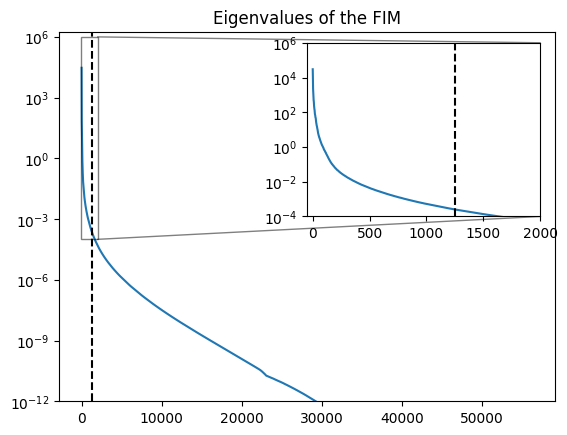

In [18]:
# # Plot eigenvalues
# plt.figure()
# plt.title("Eigenvalues of the FIM")
# plt.plot(eigvals[::-1])  # Plot the largest to the smallest eigenvalue
# plt.axvline(opt_N, c="k", ls="--")
# plt.yscale("log")
# plt.ylim(bottom=1e-12)

# # Inset axis
# ax = plt.gca()
# x1, x2, y1, y2 = -50, 2000, 1e-4, 1e6  # subregion of the original image
# axins = ax.inset_axes(
#     [0.5, 0.5, 0.47, 0.47], xlim=(x1, x2), ylim=(y1, y2), yscale="log"
# )
# axins.plot(eigvals[::-1])
# axins.axvline(opt_N, c="k", ls="--")
# ax.indicate_inset_zoom(axins, edgecolor="black")

# plt.show()

It is interesting that the number of effective parameters we found this way is located near the elbow.
I don't think this is a coincidence.
I have qualitative argument why this behavior is not a coincidence, and it can be shown using the following plot.

In [19]:
# # Look at N vs n
# N = np.arange(nparams / 10) + 1
# with Pool(25) as p:
#     n = np.array(list(p.imap(find_n_given_N, tqdm(N))))

100%|██████████████████████████████████████████████████████████████| 5633/5633 [01:38<00:00, 57.21it/s]


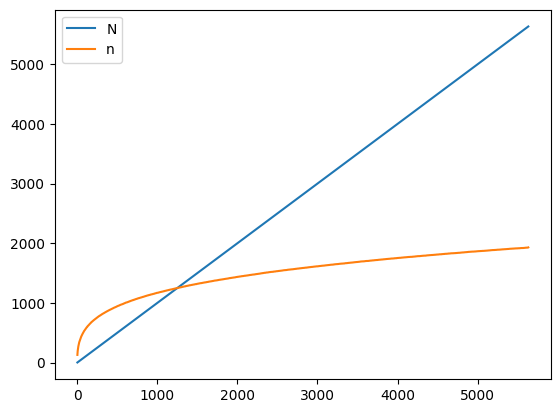

In [20]:
# plt.figure()
# plt.plot(N, N, label="N")
# plt.plot(N, n, label="n")
# plt.legend()
# plt.show()

Some description why we expect the number of effective parameters is around the elbow.

## Eigenvectors analysis

**NOTE:** The eigenvalues are sorted from the smallest to the largest.

In [21]:
# Load the eigenvalues result
eigvecs_file = JAC_DIR / f"eighvecs_entire_network_{test_val}.npy"
eigvecs = np_load(eigvecs_file)

Loading...


In [22]:
# Get the eigenvectors for the effective parameters
opt_eigvecs = eigvecs[:, -opt_N:]
# The following variables are to help plot the eigenvectors
nparams_per_layer = np.append(0, calc.get_size_opt_params()[1])
np.concatenate(
    [[f"Weights layer {n+1}", f"Bias layer {n+1}"] for n in range(settings["Nlayers"])]
)
nparams_per_layer

array([    0,  6528,   128, 16384,   128, 16384,   128, 16384,   128,
         128,     1])

Note that on the following plots, the left-most column is the sloppiest, and the right-most column is the stiffest

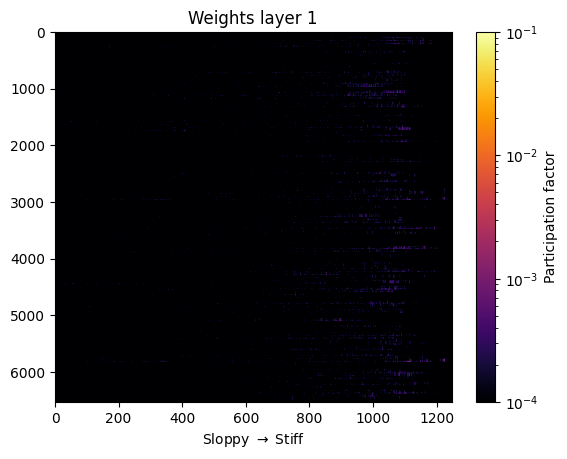

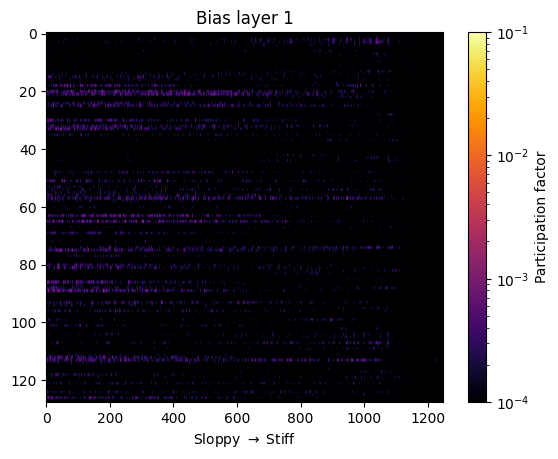

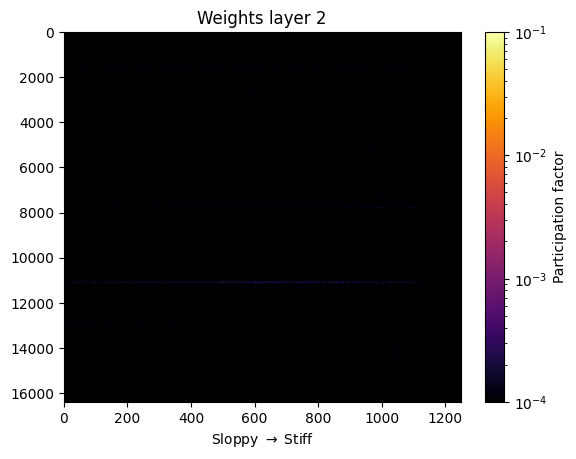

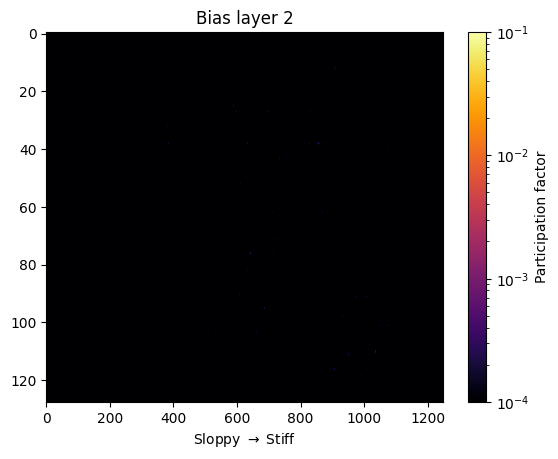

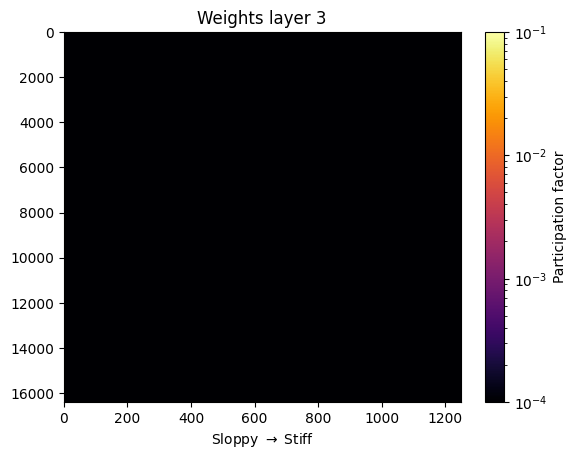

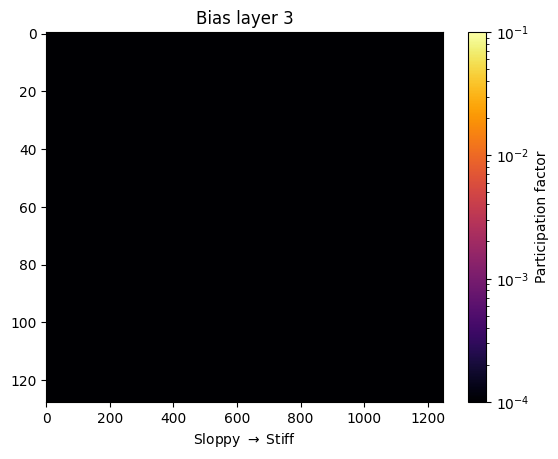

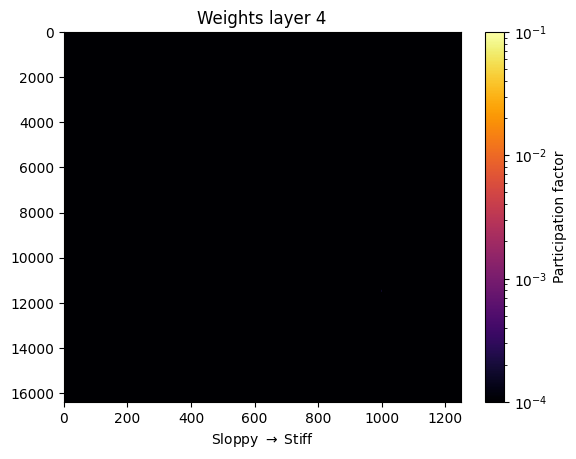

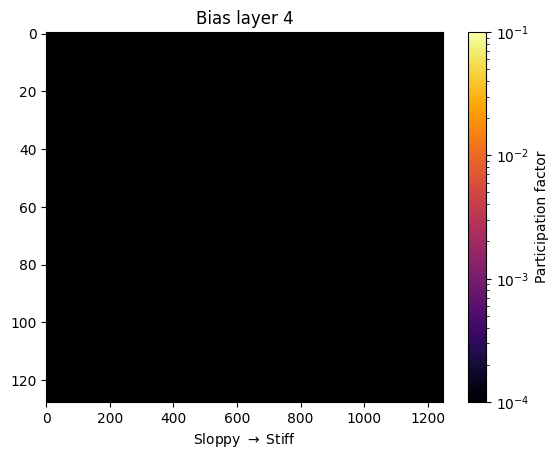

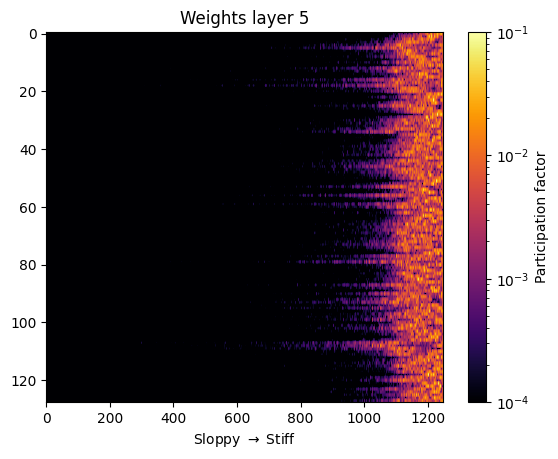

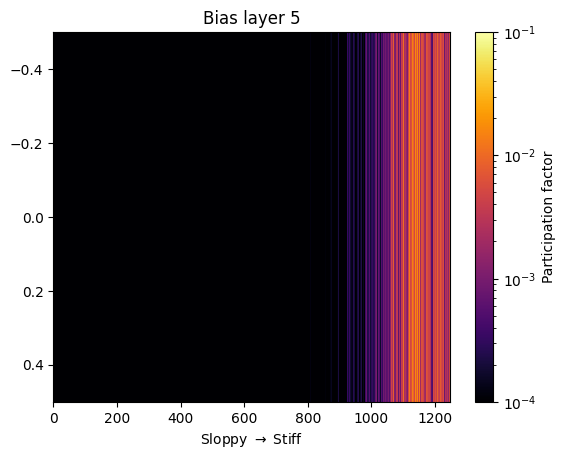

In [23]:
# # Plot participation factor for the relevant parameters. Divide the rows different
# # NN layers. This is to help see which layers are more important.
# for ii in range(len(nparams_per_layer) - 1):
#     start = sum(nparams_per_layer[: ii + 1])
#     end = start + nparams_per_layer[ii + 1]
#     # print(ii, start, end)
#     plt.figure()
#     plt.title(eigvecs_plot_titles[ii])
#     plt.imshow(
#         opt_eigvecs[start:end] ** 2 + 1e-16,
#         aspect="auto",
#         cmap="inferno",
#         norm=mpl.colors.LogNorm(vmin=1e-4, vmax=0.1),
#     )

#     plt.colorbar(label="Participation factor")
#     plt.xlabel(r"Sloppy $\rightarrow$ Stiff")
# plt.show()

# Model ensemble

Now that we know the number of effective parameters, we can compute the overall temperature scaling factor for the likelihood.
Then, the next step is to get the posterior, which we assume to be a Gaussian centered at the optimal parameters.
The covariance of the Gaussian is the inverse of the FIM likelihood plus FIM prior.
Finally, the prior to compute the FIM will be chosen to be a Xavier normal distribution, where the variance for each layer is given by
\begin{equation}
    \sigma^2 = \frac{2}{\text{fan}_{in} + \text{fan}_{out}},
\end{equation}
where $\text{fan}_{in}$ is the number of input features and $\text{fan}_{out}$ is the number of output features.

In the following, we will compute the covariance matrix of the parameters. 
However, note that we will just vary the effective parameters and fix the rest.
We can do this since we know the number of effective parameters and the eigenvectors of the FIM likelihood.

In [24]:
# Construct the FIM of the prior
def compute_xavier_variance(fan_in, fan_out):
    """Compute the Xavier normal variance given number of input and output features."""
    return 2 / (fan_in + fan_out)


# Construct variance for the prior
var_prior = []
for layer in model.layers:
    if isinstance(layer, torch.nn.Linear):
        fan_in = layer.in_features
        fan_out = layer.out_features
        s2 = compute_xavier_variance(fan_in, fan_out)
        var_weight = np.ones(fan_in * fan_out) * s2
        var_bias = np.ones(fan_out)
        var_layer = np.append(var_weight, var_bias)
        var_prior = np.append(var_prior, var_layer)
# Construct the FIM of the prior
fim_prior = scipy.sparse.diags(np.ones_like(var_prior) / var_prior)

To sample only the effective parameters, we will transform the space and do the sampling in the eigenspace instead.
Then later we will transform back the samples to the original parameter space.

In the eigenspace, the covariance matrix is given by
\begin{equation}
    \tilde{\text{Cov}} = \left( \Lambda_L + V_L^T \mathcal{I}_\pi V_L \right)^{-1},
\end{equation}
where $\Lambda_L$ is a matrix of eigenvalues of the FIM likelihood $\mathcal{I}_L$ with the corresponding eigenvectors $V_L$ and $\mathcal{I}_\pi$ is the FIM from the prior, which is in this case a diagonal matrix.

After we get the covariance matrix in eigenspace, we will do multivariate normal sampling in the eigenspace.
Then, we will transform the samples to the original parameter space.

In [25]:
# Parameter samples
p0 = bestfit_params
if test_val == "test":
    C0_times_2 = C0_times_2_test
else:
    C0_times_2 = C0_times_2_val

param_samples_file = RES_DIR / "samples_bayes_parameters.npy"
if param_samples_file.exists():
    print("Loading...")
    param_samples = np.load(param_samples_file)
else:
    # Load FIM likelihood
    fim_file = JAC_DIR / f"fim_entire_network_{test_val}.npy"
    fim_like = np_load(fim_file)
    # Covariance inverse
    # Temperature
    T = C0_times_2 / opt_N
    # Also divide the FIM likelihood by the temperature
    cov_inv = fim_like / T + fim_prior

    # Inverse this matrix to get the covariance in eigenspace
    l, v = np.linalg.eig(cov_inv)
    cov = v @ np.diag(1 / l) @ v.T

    # Samples
    nsamples = 100
    param_samples = np.random.multivariate_normal(mean=p0, cov=cov, size=nsamples)

    # Export the samples
    param_samples_file = RES_DIR / "samples_bayes_parameters.npy"
    np.save(param_samples_file, param_samples)

In [26]:
# # Some plots of the samples
# plt.figure()
# plt.plot(np.std(param_samples, axis=0))
# plt.yscale("log")
# plt.xlabel("Parameter index")
# plt.ylabel("Standard deviation")
# plt.show()

In [27]:
# Write and install model ensembles
for ii, params in tqdm(enumerate(param_samples), total=len(param_samples)):
    # Write the model
    complete_params = bestfit_params.copy()
    complete_params[-nparams:] = params
    calc.update_model_params(complete_params)  # Update parameters
    # Install model
    modelpath = RES_DIR / f"{ii:03d}" / f"DUNN_C_fimbayes_{ii:03d}"
    model.write_kim_model(modelpath)  # Write

 45%|█████████████████████████████▎                                   | 45/100 [00:21<00:26,  2.10it/s]2024-07-11 08:16:26.978 | INFO     | kliff.models.neural_network:write_kim_model:121 - KLIFF trained model written to /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/045/DUNN_C_fimbayes_045.


 91%|███████████████████████████████████████████████████████████▏     | 91/100 [00:43<00:04,  2.12it/s]2024-07-11 08:16:48.811 | INFO     | kliff.models.neural_network:write_kim_model:121 - KLIFF trained model written to /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/091/DUNN_C_fimbayes_091.


100%|████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


In [28]:
def install_uninstall_model(modelname, mode="install"):
    """This function will install or remove KIM model."""
    kim_command = "kim-api-collections-management"
    if mode == "install":
        flags = ["install", "user"]
    elif mode == "uninstall":
        flags = ["remove", "--force"]
        modelname = Path(modelname).name
    command = np.concatenate(([kim_command], flags, [modelname]))
    subprocess.run(command)


def install_uninstall_wrapper(ii):
    modelname = RES_DIR / f"{ii:03d}" / f"DUNN_C_fimbayes_{ii:03d}"
    # Uninstall first to make sure we don't use the wrong models later
    install_uninstall_model(modelname, "uninstall")
    # Install this model ensemble
    install_uninstall_model(modelname, "install")


with Pool(25) as p:
    p.map(install_uninstall_wrapper, range(100))

This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
Removing '/home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_020'. [done]

Success!
This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
Removing '/home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_022'. This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  befo

Found local item named: DUNN_C_fimbayes_011.
In source directory: /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/011/DUNN_C_fimbayes_011.
   (If you are trying to install an item from openkim.org
    rerun this command from a different working directory,
    or rename the source directory mentioned above.)

Found local item named: DUNN_C_fimbayes_013.
In source directory: /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/013/DUNN_C_fimbayes_013.
   (If you are trying to install an item from openkim.org
    rerun this command from a different working directory,
    or rename the source directory mentioned above.)

Found local item named: DUNN_C_fimbayes_017.
In source directory: /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/017/DUNN_C_fimbayes_017.
   (If you are trying to install an item from openkim.org
    rerun

Found installed driver... DUNN__MD_292677547454_000
[100%] Built target DUNN_C_fimbayes_020
Install the project...
[100%] Built target DUNN_C_fimbayes_015
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_020/libkim-api-portable-model.so

Success!
Install the project...
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_015/libkim-api-portable-model.so

Success!
[100%] Built target DUNN_C_fimbayes_017
Install the project...
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_017/libkim-api-portable-model.so

Success!
[100%] Built target DUNN_C_fimbayes_003
[100%] Built target DUNN_C_fimbayes_022
[100%] Built target DUNN_C_fimbayes_024
[100%] Built target DUNN_C_fimbayes_011
[1

This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
Removing '/home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_039'. [done]

Success!
This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
Removing '/home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_037'. [done]

Success!
Removing '/home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_036'. [done]

Success!
This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  

Found local item named: DUNN_C_fimbayes_036.
In source directory: /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/036/DUNN_C_fimbayes_036.
   (If you are trying to install an item from openkim.org
    rerun this command from a different working directory,
    or rename the source directory mentioned above.)

Found local item named: DUNN_C_fimbayes_042.
In source directory: /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/042/DUNN_C_fimbayes_042.
   (If you are trying to install an item from openkim.org
    rerun this command from a different working directory,
    or rename the source directory mentioned above.)

Found local item named: DUNN_C_fimbayes_040.
In source directory: /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/040/DUNN_C_fimbayes_040.
   (If you are trying to install an item from openkim.org
    rerun

Install the project...
Install the project...
Install the project...
[100%] Built target DUNN_C_fimbayes_034
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_029/libkim-api-portable-model.so
Removing '/home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_050'. -- Install configuration: "None"
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_036/libkim-api-portable-model.so
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_042/libkim-api-portable-model.so
[done]

Success!
Install the project...

Success!

Success!

Success!
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-m

[100%] Built target DUNN_C_fimbayes_048
Install the project...
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_048/libkim-api-portable-model.so

Success!
This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
Removing '/home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_069'. [done]

Success!
[100%] Built target DUNN_C_fimbayes_047
Install the project...
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_047/libkim-api-portable-model.so

Success!
This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
Removing '/home/byu.local/y

Found local item named: DUNN_C_fimbayes_064.
In source directory: /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/064/DUNN_C_fimbayes_064.
   (If you are trying to install an item from openkim.org
    rerun this command from a different working directory,
    or rename the source directory mentioned above.)

Found local item named: DUNN_C_fimbayes_067.
In source directory: /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/067/DUNN_C_fimbayes_067.
   (If you are trying to install an item from openkim.org
    rerun this command from a different working directory,
    or rename the source directory mentioned above.)

Found local item named: DUNN_C_fimbayes_069.
In source directory: /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/069/DUNN_C_fimbayes_069.
   (If you are trying to install an item from openkim.org
    rerun

Install the project...
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_063/libkim-api-portable-model.so

Success!
[100%] Built target DUNN_C_fimbayes_067
This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
Removing '/home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_079'. [done]

Success!
Install the project...
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_067/libkim-api-portable-model.so

Success!
This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
This will remove all files associated with these items.
  Use the '

Found local item named: DUNN_C_fimbayes_077.
In source directory: /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/077/DUNN_C_fimbayes_077.
   (If you are trying to install an item from openkim.org
    rerun this command from a different working directory,
    or rename the source directory mentioned above.)

This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
Removing '/home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_096'. [done]

Success!
This will remove all files associated with these items.
  Use the '--interactive' option to request confirmation
  before attempting to remove each item.
Removing '/home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_093'. [done]

Success!
This will remove all files associated with

Found installed driver... DUNN__MD_292677547454_000
Found installed driver... DUNN__MD_292677547454_000
Found local item named: DUNN_C_fimbayes_094.
In source directory: /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/094/DUNN_C_fimbayes_094.
   (If you are trying to install an item from openkim.org
    rerun this command from a different working directory,
    or rename the source directory mentioned above.)

Found installed driver... DUNN__MD_292677547454_000
Found local item named: DUNN_C_fimbayes_096.
In source directory: /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/fim/results/mingjian_partition_128_128_128_128/096/DUNN_C_fimbayes_096.
   (If you are trying to install an item from openkim.org
    rerun this command from a different working directory,
    or rename the source directory mentioned above.)

Found installed driver... DUNN__MD_292677547454_000
Found installed driver... DUNN__MD_292677547454_000
Foun


Success!
[100%] Built target DUNN_C_fimbayes_091
Install the project...
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_091/libkim-api-portable-model.so

Success!
[100%] Built target DUNN_C_fimbayes_097
[100%] Built target DUNN_C_fimbayes_098
Install the project...
Install the project...
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_097/libkim-api-portable-model.so
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/DUNN_C_fimbayes_098/libkim-api-portable-model.so

Success!

Success!
[100%] Built target DUNN_C_fimbayes_093
Install the project...
-- Install configuration: "None"
-- Installing: /home/byu.local/yonatank/.kim-api/2.2.1+GNU.GNU.GNU.2020-12-28-19-51-27/portable-models-dir/D